# Imports

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, kendalltau
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re
import string
import nltk
import random
# import libvoikko

In [11]:
import warnings
warnings.filterwarnings("ignore")

# Data Importing and Sorting

In [2]:
files = os.listdir('corpus')
files.remove('.DS_Store')
files.remove('scores_ru-en.csv')
scaler = MinMaxScaler()
for file_ in files:
  name = file_.split('-')[0] + file_.split('-')[1]
  vars()[name] = pd.read_csv(os.path.join('corpus', file_, 'scores.csv'))
  vars()[name].drop(columns = ['source', 'annotators', 'z-score'], inplace = True)
  vars()[name]['avg-score'] = scaler.fit_transform(vars()[name]['avg-score'].values.reshape(-1,1)) #normalizing values betwewen 0 and 1

In [3]:
english = csen.copy()
for df in [deen, ruen, zhen]:
  english = english.append(df)

In [4]:
finnish = enfi.copy()
chinese = enzh.copy()

# Train, Dev & Test Split

In [5]:
en_train, en_dev = train_test_split(english, shuffle = True, test_size = 0.2, random_state = 7)
en_dev, en_test = train_test_split(en_dev, shuffle = True, test_size = 0.5, random_state = 7)

fin_train, fin_dev = train_test_split(finnish, shuffle = True, test_size = 0.2, random_state = 7)
fin_dev, fin_test = train_test_split(fin_dev, shuffle = True, test_size = 0.5, random_state = 7)

ch_train, ch_dev = train_test_split(chinese, shuffle = True, test_size = 0.2, random_state = 7)
ch_dev, ch_test = train_test_split(ch_dev, shuffle = True, test_size = 0.5, random_state = 7)

# Cleaning Function

In [68]:
def clean(text_list,
          command_dict = None,
#           lower = False,
#           keep_numbers = False,
#           keep_expression = False,
#           remove_char = False,
#           remove_stop = False,
#           remove_tag = False,
#           lemmatize = False,
#           stemmer = False,
          english = True
          ):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    
    if english:
        lang = 'english'
    else:
        lang = 'finnish'
    
    stop = set(stopwords.words(lang))
    stem = SnowballStemmer(lang)
    
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        if command_dict['lower']:
            text = text.lower()
            
        #KEEP NUMBERS AS TOKENS
        if command_dict['keep_numbers']:
            text = re.sub("[\d+]", 'NUMBER', text)
        
        #KEEP '?' and '!' AS TOKENS
        if command_dict['keep_expression']:
            text = re.sub("[\?|\!]", 'EXPRESSION', text)
            
        #REMOVE THAT IS NOT TEXT
        if command_dict['remove_char']:
            text = re.sub("[^a-zA-Z]", ' ', text)
            
        #REMOVE TAGS
        if command_dict['remove_tag']:
            text = BeautifulSoup(text).get_text()
        
        #REMOVE STOP WORDS
        if command_dict['remove_stop']:
            text = ' '.join([word for word in text.split(' ') if word not in stop])
        
        #LEMMATIZATION
        if command_dict['lemmatize']:
            if english:
                lemma = WordNetLemmatizer()
                text = " ".join(lemma.lemmatize(word) for word in text.split())
#             else:
#                 lemma = libvoikko.Voikko(u"fi")
#                 text = " ".join(lemma.analyze(word)[0]['BASEFORM'] for word in text.split())
        
        #STEMMER
        if command_dict['stemmer']:
            text = " ".join(stem.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def clean_zh_stopwords(text_list, stopwords_set='merged'):
    """
    Function that removes chinese stopwords
    
    :param stopwords_set: remove words of both sets (merged), just the 1st (fst) or just the second (snd) 
    """
    updates = []
    
    zh_stopwords1 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords1.txt', 'r', encoding='utf-8').readlines()]
    zh_stopwords2 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords2.txt', 'r', encoding='utf-8').readlines()]
    
    if stopwords_set == 'merged':
        stop = list(set(zh_stopwords1 + zh_stopwords2))
    elif stopwords_set == 'fst':
        stop = zh_stopwords1
    elif stopwords_set == 'snd':
        stop = zh_stopwords2
        

    for j in tqdm(range(len(text_list))):
        text = text_list[j]
        text = ' '.join([word for word in text.split(' ') if word not in stop])
        updates.append(text)
        
    return updates
        
    
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"Text": list_updated}))

# Baseline encoding

In [7]:
baseline_encoder_reference = CountVectorizer(max_features =  15000)#settting limit for computational reasons
# baseline_encoder_translation = CountVectorizer(max_features = 5000)

# Correlation Function

In [8]:
def cos_sim(reference, translation):
    
    cos = []
    for i in range(reference.shape[0]):
        cos.append(cosine_similarity(reference[i], translation[i])[0])
    cos = np.array(cos)
    cos.shape = (cos.shape[0],)
    
    return cos

In [9]:
def correlation(y_train, pred_train, y_dev, pred_dev, y_test, pred_test, print = False):

    corr_train, corr_train_pvalue = pearsonr(y_train, pred_train)
    corr_dev, corr_dev_pvalue = pearsonr(y_dev, pred_dev)
    corr_test, corr_test_pvalue = pearsonr(y_test, pred_test)

    corr_ktau_train, corr_ktau_train_pvalue = kendalltau(y_train, pred_train)
    corr_ktau_dev, corr_ktau_dev_pvalue = kendalltau(y_dev, pred_dev)
    corr_ktau_test, corr_ktau_test_pvalue = kendalltau(y_test, pred_test)
    
    if print:
        print(f'Pearson correlation between cosine similarity and score on training set: {corr_train} (p-value < 0.001: {corr_train_pvalue < 0.001}); and Kendall Tau: {corr_ktau_train} (p-value < 0.001: {corr_ktau_train_pvalue < 0.001})')
        print(f'Pearson correlation between cosine similarity and score on development set: {corr_dev} (p-value < 0.001: {corr_dev_pvalue < 0.001}); and Kendall Tau: {corr_ktau_dev} (p-value < 0.001: {corr_ktau_dev_pvalue < 0.001})')
        print(f'Pearson correlation between cosine similarity and score on test set: {corr_test} (p-value < 0.001: {corr_test_pvalue < 0.001}); and Kendall Tau: {corr_ktau_test} (p-value < 0.001: {corr_ktau_test_pvalue < 0.001})')

    return corr_train, corr_dev, corr_test, corr_ktau_train, corr_ktau_dev, corr_ktau_test

# Randomized search in cleaning methods

In [10]:
def random_cleaning_config(previuous_config):
    
    while True:
        random_cleaning_paramspace = {'lower' : random.choice([False, True]),
                                      'keep_numbers' : random.choice([False, True]),
                                      'keep_expression' : random.choice([False, True]),
                                      'remove_char' : random.choice([False, True]),
                                      'remove_stop' : random.choice([False, True]),
                                      'remove_tag' : random.choice([False, True]),
                                      'lemmatize' : random.choice([False, True]),
                                      'stemmer' : random.choice([False, True])}
            
        if random_cleaning_paramspace not in previuous_config:
            break
    
    return random_cleaning_paramspace

In [71]:
types = ['train', 'dev', 'test']
results = {}
for iteration in tqdm(range(100)):

    cleaning_config = random_cleaning_config(list(results.keys()))
   
    for i,df in enumerate([en_train, en_dev, en_test]):
        
        df_noindex = df.reset_index(drop = True).copy()
        
        cleaned_df = pd.DataFrame()

        for column in ['reference', 'translation']:

            cleaned_df[column] = clean(df_noindex[column], cleaning_config)


            if i == 0 and column == 'reference':
                encoded_reference= baseline_encoder_reference.fit_transform(cleaned_df[column]).todense()

            elif column == 'reference':
                encoded_reference = baseline_encoder_reference.transform(cleaned_df[column]).todense()
            else:
                encoded_translation = baseline_encoder_reference.transform(cleaned_df[column]).todense()

        cos_name = 'cos_sim_' + types[i]
        vars()[cos_name] = cos_sim(encoded_reference, encoded_translation)


    results[str(cleaning_config)] = (correlation(cos_sim_train, en_train['avg-score'], cos_sim_dev, en_dev['avg-score'], cos_sim_test, en_test['avg-score']))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/62150 [00:00<?, ?it/s]

C:\Users\utente\anaconda3\envs\tm\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/62150 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

  0%|          | 0/7769 [00:00<?, ?it/s]

# Graphical Visualization of results

In [72]:
results

{"{'lower': True, 'keep_numbers': False, 'keep_expression': False, 'remove_char': True, 'remove_stop': True, 'remove_tag': True, 'lemmatize': True, 'stemmer': True}": (0.28181466953341694,
  0.27616330428797625,
  0.26580347805511134,
  0.19612547145999,
  0.19776717690297677,
  0.18282530481276443),
 "{'lower': False, 'keep_numbers': True, 'keep_expression': False, 'remove_char': True, 'remove_stop': False, 'remove_tag': False, 'lemmatize': True, 'stemmer': False}": (0.27435494126204507,
  0.2777869432011847,
  0.27163219486311396,
  0.18749285281250838,
  0.18812758399414917,
  0.18611773385878597),
 "{'lower': True, 'keep_numbers': True, 'keep_expression': True, 'remove_char': True, 'remove_stop': True, 'remove_tag': False, 'lemmatize': False, 'stemmer': False}": (0.2725843393969255,
  0.27266560341837,
  0.2596456203032596,
  0.19007941248661248,
  0.19786360811386472,
  0.18006823089794607),
 "{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': False, '

In [73]:
results_df = pd.DataFrame(results).T.set_axis(['pearson_train', 'pearson_dev', 'pearson_test', 'ktau_train', 'ktau_dev', 'ktau_test'], axis = 1)

In [75]:
results_df.to_csv('randomized_search.csv')

In [3]:
results_df = pd.read_csv('grid parameters/randomized_search.csv', index_col = 0)

In [4]:
results_df.head()

,pearson_train,pearson_dev,pearson_test,ktau_train,ktau_dev,ktau_test
"{'lower': True, 'keep_numbers': False, 'keep_expression': False, 'remove_char': True, 'remove_stop': True, 'remove_tag': True, 'lemmatize': True, 'stemmer': True}",0.281815,0.276163,0.265803,0.196125,0.197767,0.182825
"{'lower': False, 'keep_numbers': True, 'keep_expression': False, 'remove_char': True, 'remove_stop': False, 'remove_tag': False, 'lemmatize': True, 'stemmer': False}",0.274355,0.277787,0.271632,0.187493,0.188128,0.186118
"{'lower': True, 'keep_numbers': True, 'keep_expression': True, 'remove_char': True, 'remove_stop': True, 'remove_tag': False, 'lemmatize': False, 'stemmer': False}",0.272584,0.272666,0.259646,0.190079,0.197864,0.180068
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': False, 'remove_stop': False, 'remove_tag': True, 'lemmatize': False, 'stemmer': False}",0.272915,0.276431,0.270348,0.186747,0.186266,0.183594
"{'lower': True, 'keep_numbers': True, 'keep_expression': False, 'remove_char': True, 'remove_stop': True, 'remove_tag': True, 'lemmatize': True, 'stemmer': True}",0.282847,0.279138,0.268667,0.196792,0.200797,0.184700


In [5]:
for data_type in ['train', 'dev', 'test']:
    results_df[f'avg_{data_type}'] = (results_df[f'pearson_{data_type}'] + results_df[f'ktau_{data_type}']) / 2

In [6]:
results_df.sort_values('avg_train', ascending = False)

,pearson_train,pearson_dev,pearson_test,ktau_train,ktau_dev,ktau_test,avg_train,avg_dev,avg_test
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': True, 'remove_stop': True, 'remove_tag': True, 'lemmatize': False, 'stemmer': True}",0.294044,0.287254,0.274383,0.202465,0.204518,0.189626,0.248254,0.245886,0.232004
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': True, 'remove_stop': True, 'remove_tag': False, 'lemmatize': True, 'stemmer': True}",0.293874,0.286868,0.273132,0.202518,0.203856,0.188924,0.248196,0.245362,0.231028
"{'lower': False, 'keep_numbers': True, 'keep_expression': False, 'remove_char': True, 'remove_stop': True, 'remove_tag': False, 'lemmatize': False, 'stemmer': True}",0.293615,0.287462,0.276447,0.202324,0.205271,0.190054,0.247969,0.246366,0.233251
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': False, 'remove_stop': True, 'remove_tag': False, 'lemmatize': False, 'stemmer': False}",0.288672,0.287448,0.272073,0.199776,0.205095,0.186938,0.244224,0.246271,0.229506
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': False, 'remove_stop': True, 'remove_tag': False, 'lemmatize': True, 'stemmer': False}",0.288472,0.287902,0.273128,0.198898,0.204710,0.188214,0.243685,0.246306,0.230671
...,...,...,...,...,...,...,...,...,...
"{'lower': False, 'keep_numbers': False, 'keep_expression': False, 'remove_char': False, 'remove_stop': False, 'remove_tag': True, 'lemmatize': True, 'stemmer': False}",0.271867,0.276624,0.270740,0.185707,0.185826,0.185252,0.228787,0.231225,0.227996
"{'lower': True, 'keep_numbers': False, 'keep_expression': False, 'remove_char': False, 'remove_stop': False, 'remove_tag': True, 'lemmatize': True, 'stemmer': False}",0.271883,0.277032,0.272043,0.185689,0.186161,0.185707,0.228786,0.231596,0.228875
"{'lower': False, 'keep_numbers': False, 'keep_expression': False, 'remove_char': True, 'remove_stop': False, 'remove_tag': True, 'lemmatize': True, 'stemmer': False}",0.271917,0.274398,0.269356,0.185330,0.183812,0.184309,0.228624,0.229105,0.226832
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': True, 'remove_stop': False, 'remove_tag': True, 'lemmatize': False, 'stemmer': False}",0.271155,0.273887,0.268235,0.185304,0.184064,0.182495,0.228229,0.228976,0.225365


C:\Users\utente\anaconda3\envs\text\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


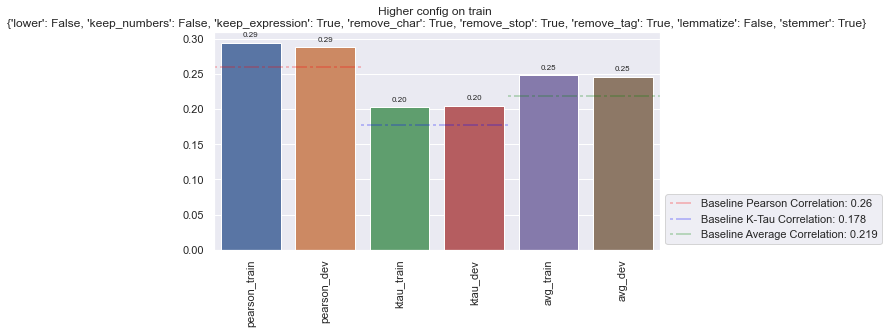

C:\Users\utente\anaconda3\envs\text\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


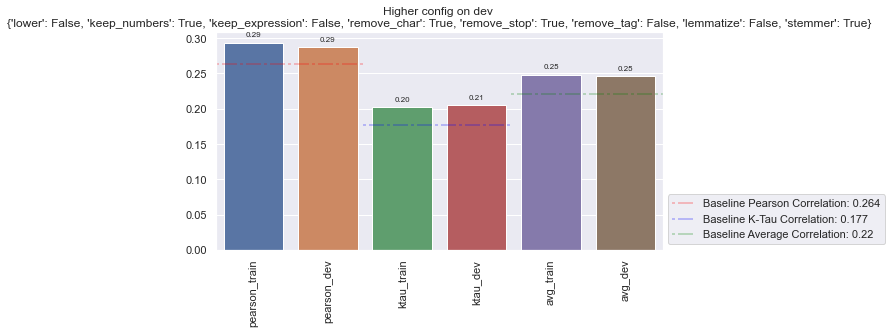

In [54]:
sns.set(rc={"figure.figsize":(8, 4)})

for data_type in ['train', 'dev']:
    fig = sns.barplot(results_df.drop(columns = ['pearson_test', 'ktau_test', 'avg_test']).sort_values(f'avg_{data_type}', ascending = False).iloc[0].index,
                  results_df.drop(columns = ['pearson_test', 'ktau_test', 'avg_test']).sort_values(f'avg_{data_type}', ascending = False).iloc[0].values)
    # Iterrating over the bars one-by-one
    for bar in fig.patches:
      # Using Matplotlib's annotate function and
      # passing the coordinates where the annotation shall be done
      # x-coordinate: bar.get_x() + bar.get_width() / 2
      # y-coordinate: bar.get_height()
      # free space to be left to make graph pleasing: (0, 8)
      # ha and va stand for the horizontal and vertical alignment
        fig.annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
    fig.set_title(f'Higher config on {data_type} \n' + results_df.sort_values(f'avg_{data_type}', ascending = False).index[0])
    
    if data_type == 'train':
        
        baseline_pearson = 0.26017539905192383
        baseline_ktau = 0.17756842511850235
        
    else:
        
        baseline_pearson = 0.26357211511565304
        baseline_ktau = 0.17713590385048059
        
    avg = (baseline_pearson+baseline_ktau)/2
        
    line1 = plt.axhline(baseline_pearson, 0, 0.33, color = 'red', alpha = 0.3, label = f'Baseline Pearson Correlation: {round(baseline_pearson,3)}')
    line1.set_dashes([2, 2, 10, 2])
    
    line2 = plt.axhline(baseline_ktau, 0.33, 0.66, color = 'blue', alpha = 0.3, label = f'Baseline K-Tau Correlation: {round(baseline_ktau,3)}')
    line2.set_dashes([2, 2, 10, 2])
    
    line3 = plt.axhline(avg, 0.66, 1, color = 'green', alpha = 0.3, label = f'Baseline Average Correlation: {round(avg,3)}')
    line3.set_dashes([2, 2, 10, 2])
    
    plt.legend(bbox_to_anchor=(1,0), loc = 'lower left')
    plt.show()

In [19]:
results_df.sort_values(f'avg_dev', ascending = False)

,pearson_train,pearson_dev,pearson_test,ktau_train,ktau_dev,ktau_test,avg_train,avg_dev,avg_test
"{'lower': False, 'keep_numbers': True, 'keep_expression': False, 'remove_char': True, 'remove_stop': True, 'remove_tag': False, 'lemmatize': False, 'stemmer': True}",0.293615,0.287462,0.276447,0.202324,0.205271,0.190054,0.247969,0.246366,0.233251
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': False, 'remove_stop': True, 'remove_tag': False, 'lemmatize': False, 'stemmer': True}",0.287874,0.287143,0.277339,0.199390,0.205566,0.194096,0.243632,0.246354,0.235717
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': False, 'remove_stop': True, 'remove_tag': False, 'lemmatize': True, 'stemmer': False}",0.288472,0.287902,0.273128,0.198898,0.204710,0.188214,0.243685,0.246306,0.230671
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': False, 'remove_stop': True, 'remove_tag': False, 'lemmatize': False, 'stemmer': False}",0.288672,0.287448,0.272073,0.199776,0.205095,0.186938,0.244224,0.246271,0.229506
"{'lower': False, 'keep_numbers': True, 'keep_expression': True, 'remove_char': False, 'remove_stop': True, 'remove_tag': False, 'lemmatize': False, 'stemmer': True}",0.287663,0.286423,0.277294,0.199042,0.205999,0.193816,0.243352,0.246211,0.235555
...,...,...,...,...,...,...,...,...,...
"{'lower': False, 'keep_numbers': False, 'keep_expression': False, 'remove_char': False, 'remove_stop': False, 'remove_tag': True, 'lemmatize': False, 'stemmer': False}",0.272008,0.275760,0.268999,0.186138,0.185407,0.182734,0.229073,0.230583,0.225867
"{'lower': True, 'keep_numbers': False, 'keep_expression': False, 'remove_char': True, 'remove_stop': False, 'remove_tag': True, 'lemmatize': True, 'stemmer': False}",0.272907,0.275574,0.272679,0.186152,0.184525,0.186268,0.229530,0.230050,0.229474
"{'lower': False, 'keep_numbers': False, 'keep_expression': False, 'remove_char': True, 'remove_stop': False, 'remove_tag': True, 'lemmatize': True, 'stemmer': False}",0.271917,0.274398,0.269356,0.185330,0.183812,0.184309,0.228624,0.229105,0.226832
"{'lower': False, 'keep_numbers': False, 'keep_expression': True, 'remove_char': True, 'remove_stop': False, 'remove_tag': True, 'lemmatize': False, 'stemmer': False}",0.271155,0.273887,0.268235,0.185304,0.184064,0.182495,0.228229,0.228976,0.225365
